<a href="https://colab.research.google.com/github/YasirHabib/Deep-Learning-Convolutional-Neural-Networks-in-Python/blob/master/svhn_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
from sklearn.utils import shuffle

In [0]:
class Model(nn.Module):
  def __init__(self, size, K):
    super(Model, self).__init__()
    # define the layers
    # Input channels = 3, output channels = 20, filter size = (5,5)
    # padding=0 (valid mode), padding=4 (full mode), padding=2 (same mode)
    self.conv1 = nn.Conv2d(3, 20, kernel_size=5, stride=1, padding=2)
    self.conv2 = nn.Conv2d(20, 50, kernel_size=5, stride=1, padding=2)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.linear1 = nn.Linear(50*8*8, size)
    self.linear2 = nn.Linear(size, K)
    self.dropout = nn.Dropout(0.25)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 50*8*8) ## reshaping
    x = self.dropout(x)
    x = F.relu(self.linear1(x))
    x = self.dropout(x)
    x = self.linear2(x)
    return x
    # Note: no final softmax!
    # just like Tensorflow, it's included in cross-entropy function

In [0]:
class CNN():
  def __init__(self, size):
    self.size = size
    
  def fit(self, Xtrain, Ytrain, Xtest, Ytest, training_epochs=5, batch_sz=500):
    N = Xtrain.shape[0]
    K = len(set(Ytrain))
    
    Xtest = Xtest[-10000:]
    Ytest = Ytest[-10000:]
    
    # convert the data arrays into torch tensors
    Xtrain = torch.from_numpy(Xtrain).float()
    Ytrain = torch.from_numpy(Ytrain).long()
    Xtest = torch.from_numpy(Xtest).float()
    Ytest = torch.from_numpy(Ytest).long()
    
    model = Model(self.size, K)
    
    loss = nn.CrossEntropyLoss()
    
    optimizer = optim.Adam(model.parameters())
    
    def train(model, loss, optimizer, inputs, labels):
      inputs = Variable(inputs, requires_grad=False)
      labels = Variable(labels, requires_grad=False)
      
      optimizer.zero_grad()
      
      # get output from the model, given the inputs
      logits = model(inputs)
      
      # get loss for the predicted output
      cost = loss(logits, labels)
      
      # get gradients w.r.t to parameters
      cost.backward()
      
      # update parameters
      optimizer.step()
      
      return cost.item()
    
    def test(model, loss, inputs, labels):
      inputs = Variable(inputs, requires_grad=False)
      labels = Variable(labels, requires_grad=False)
      
      logits = model(inputs)
      cost = loss(logits, labels)
      
      return cost.item()
    
    def predict(model, inputs):
      inputs = Variable(inputs, requires_grad=False)
      
      logits = model(inputs)
      return logits.data.numpy().argmax(axis=1)
    
    n_batches = N // batch_sz
    
    train_costs = []
    test_costs = []
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(training_epochs):
      for j in range(n_batches):
        Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz)]
        Ybatch = Ytrain[j*batch_sz:(j*batch_sz + batch_sz)]
        
        train_c=train(model, loss, optimizer, Xbatch, Ybatch)
        
        if j % 20 == 0:
          train_costs.append(train_c)

          test_c=test(model, loss, Xtest, Ytest)
          test_costs.append(test_c)
          
          p_train = predict(model, Xbatch)
          p_test = predict(model, Xtest)
          
          acc_train = np.mean(p_train == Ybatch.numpy())
          train_accuracies.append(acc_train)

          acc_test = np.mean(p_test == Ytest.numpy())
          test_accuracies.append(acc_test)
          
          print("Epoch", (epoch+1), "Training Cost", "%.2f" % train_c, "Test cost", "%.2f" % test_c, "Training Acc", "%.2f" % acc_train, "Test Acc", "%.2f" % acc_test)
          
    plt.plot(train_costs, label='Training Cost')
    plt.plot(test_costs, label='Test Cost')
    plt.legend()
    plt.show()
    
    plt.plot(train_accuracies, label='Training accuracy')
    plt.plot(test_accuracies, label='Test accuracy')
    plt.legend()
    plt.show()

In [0]:
def main():
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount = True)
  
  train = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/Convolutional Neural Networks/train_32x32.mat')
  test = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/Convolutional Neural Networks/test_32x32.mat')
  
  Xtrain = train['X']
  Ytrain = train['y']
  #print(Xtrain.shape)           (32, 32, 3, 73257)
  #print(Ytrain.shape)           (73257, 1)
  Ytrain = Ytrain.flatten() - 1
  
  Xtest = test['X']
  Ytest = test['y']
  #print(Xtest.shape)            (32, 32, 3, 26032)
  #print(Ytest.shape)            (26032, 1)
  Ytest = Ytest.flatten() - 1
  
  Xtrain = (Xtrain.transpose(3,2,0,1) / 255).astype(np.float32)
  Xtest = (Xtest.transpose(3,2,0,1) / 255).astype(np.float32)
  
  model = CNN(500)
  model.fit(Xtrain, Ytrain, Xtest, Ytest)

Mounted at /content/gdrive
Epoch 1 Training Cost 2.30 Test cost 2.24 Training Acc 0.20 Test Acc 0.20
Epoch 1 Training Cost 2.22 Test cost 2.22 Training Acc 0.20 Test Acc 0.20
Epoch 1 Training Cost 2.20 Test cost 2.18 Training Acc 0.23 Test Acc 0.23
Epoch 1 Training Cost 2.05 Test cost 1.95 Training Acc 0.23 Test Acc 0.29
Epoch 1 Training Cost 1.46 Test cost 1.43 Training Acc 0.56 Test Acc 0.52
Epoch 1 Training Cost 1.20 Test cost 1.15 Training Acc 0.62 Test Acc 0.63
Epoch 1 Training Cost 0.98 Test cost 0.97 Training Acc 0.69 Test Acc 0.70
Epoch 1 Training Cost 0.80 Test cost 0.86 Training Acc 0.71 Test Acc 0.74
Epoch 2 Training Cost 0.94 Test cost 0.83 Training Acc 0.73 Test Acc 0.76
Epoch 2 Training Cost 0.65 Test cost 0.78 Training Acc 0.80 Test Acc 0.77
Epoch 2 Training Cost 0.80 Test cost 0.75 Training Acc 0.76 Test Acc 0.78
Epoch 2 Training Cost 0.85 Test cost 0.71 Training Acc 0.74 Test Acc 0.79
Epoch 2 Training Cost 0.62 Test cost 0.69 Training Acc 0.85 Test Acc 0.80
Epoch 2 Tra

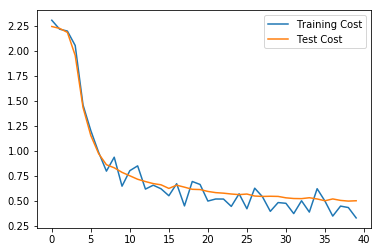

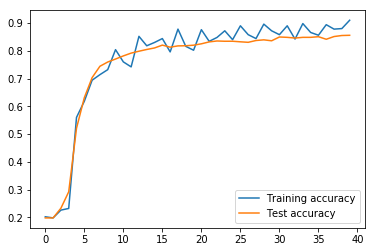

In [6]:
if __name__ == '__main__':
  main()